In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torchvision.io import read_image
# plt.ion()   # interactive mode

In [2]:
from tqdm.notebook import tqdm

In [3]:
from PIL import Image
from src.utils.image_stuff import image_stuff

In [4]:
def read_bbox(bbox_path):
    
    bbox = []
    with open(bbox_path, "r") as f:
        for line in f:
            bbox.append(int(line.strip()))
    return bbox

In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, bbox_dir, transform=None, target_transform=None):
        self.images_dir = images_dir
        self.bbox_dir = bbox_dir
        self.fnames = np.array([f'{f[:-4]}' for f in sorted(os.listdir(f'{images_dir}'))])
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, f"{self.fnames[idx]}.jpg")
        image =  Image.open(img_path)
        bbox = read_bbox(os.path.join(self.bbox_dir, f"{self.fnames[idx]}_x224.txt"))
        bbox = torch.FloatTensor(bbox)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, bbox

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
images_dir = "datasets/dataset_mix"
bbox_dir = "datasets/CNN_v1_output"

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test':
     transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


image_datasets = {x: Dataset(os.path.join(images_dir, x),
#                              os.path.join(bbox_dir, x),
                             bbox_dir,
                             data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}


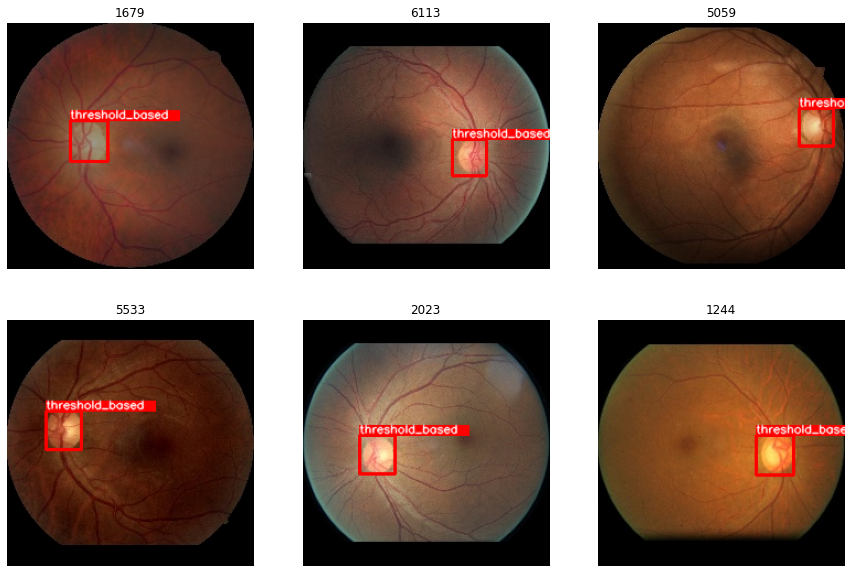

In [9]:
figure = plt.figure(figsize=(15, 10))
cols, rows = 3, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(image_datasets["train"]), size=(1,)).item()
    img, bbox = image_datasets["train"][sample_idx]
    MEAN = torch.tensor([0.485, 0.456, 0.406])
    STD = torch.tensor([0.229, 0.224, 0.225])

    img = img * STD[:, None, None] + MEAN[:, None, None]
    img = (img*255).numpy().astype(np.uint8)
    figure.add_subplot(rows, cols, i)
    plt.title(sample_idx)
    plt.axis("off")
    bbox_image = image_stuff.draw_bbox(img.transpose(1, 2, 0), bbox, "threshold_based")
    plt.imshow(bbox_image, cmap="gray")
plt.show()

In [10]:
# https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
def bbox_iou(box_a, box_b):
    # determine the (x, y)-coordinates of the intersection rectangle
    x_a = max(box_a[0], box_b[0])
    y_a = max(box_a[1], box_b[1])
    x_b = min(box_a[2], box_b[2])
    y_b = min(box_a[3], box_b[3])
    # compute the area of intersection rectangle
    inter_area = max(0, x_b - x_a + 1) * max(0, y_b - y_a + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    box_a_area = (box_a[2] - box_a[0] + 1) * (box_a[3] - box_a[1] + 1)
    box_b_area = (box_b[2] - box_b[0] + 1) * (box_b[3] - box_b[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = inter_area / float(box_a_area + box_b_area - inter_area)
    # return the intersection over union value
    return iou

In [11]:
def train_model(model, optimizer, criterion, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float("inf")

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            epoch_loss = 0.
            epoch_mean_iou = 0.
            running_sum_iou = 0.
            
            # Iterate over data.
            for inputs, bboxes_y in tqdm(dataloaders[phase], leave=False):
                inputs = inputs.to(device)
                bboxes_y = bboxes_y.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    bboxes_output = model(inputs)
                    
                    loss = criterion(bboxes_output, bboxes_y)


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                bathc_sum_iou = 0
                for box_a, box_b in zip(bboxes_y, bboxes_output.tolist()):
                    bathc_sum_iou += bbox_iou(box_a, box_b)
                running_sum_iou += bathc_sum_iou

            if phase == 'train':
                scheduler.step()
            epoch_mean_iou = running_sum_iou / dataset_sizes[phase]
            epoch_loss = running_loss / dataset_sizes[phase]


            print(f'{phase} Loss: {epoch_loss:.4f}, MeanIOU: {epoch_mean_iou:.2f}')

            # deep copy the best model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:4f}')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model


In [12]:
model_ft = models.resnet34(pretrained=False)
num_ftrs = model_ft.fc.in_features
# The size of each output sample is set to 4 for bbox coordinates
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.SmoothL1Loss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)



In [13]:
model_ft = train_model(model_ft, optimizer_ft,criterion,
                         exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------


/home/hue/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 24.8376, MeanIOU: 0.32


val Loss: 3.3805, MeanIOU: 0.67

Epoch 1/14
----------


train Loss: 4.3704, MeanIOU: 0.61


val Loss: 2.7881, MeanIOU: 0.71

Epoch 2/14
----------


train Loss: 3.0691, MeanIOU: 0.69


val Loss: 4.0408, MeanIOU: 0.63

Epoch 3/14
----------


train Loss: 2.1347, MeanIOU: 0.76


val Loss: 3.3932, MeanIOU: 0.65

Epoch 4/14
----------


train Loss: 1.7154, MeanIOU: 0.79


val Loss: 0.9869, MeanIOU: 0.86

Epoch 5/14
----------


train Loss: 1.0567, MeanIOU: 0.85


val Loss: 0.5816, MeanIOU: 0.90

Epoch 6/14
----------


train Loss: 0.9098, MeanIOU: 0.87


val Loss: 0.5834, MeanIOU: 0.90

Epoch 7/14
----------


train Loss: 0.9273, MeanIOU: 0.86


val Loss: 0.8990, MeanIOU: 0.86

Epoch 8/14
----------


train Loss: 0.8510, MeanIOU: 0.87


val Loss: 0.7337, MeanIOU: 0.88

Epoch 9/14
----------


train Loss: 0.8033, MeanIOU: 0.88


val Loss: 0.8700, MeanIOU: 0.86

Epoch 10/14
----------


train Loss: 0.7579, MeanIOU: 0.88


val Loss: 0.5660, MeanIOU: 0.90

Epoch 11/14
----------


train Loss: 0.7453, MeanIOU: 0.88


val Loss: 0.5992, MeanIOU: 0.90

Epoch 12/14
----------


train Loss: 0.7324, MeanIOU: 0.88


val Loss: 0.4805, MeanIOU: 0.91

Epoch 13/14
----------


train Loss: 0.7428, MeanIOU: 0.88


val Loss: 0.5792, MeanIOU: 0.90

Epoch 14/14
----------


train Loss: 0.7765, MeanIOU: 0.88


val Loss: 0.5178, MeanIOU: 0.91


Training complete in 53m 47s
Best val Loss: 0.480503


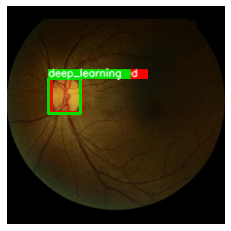

In [14]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# load your image(s)
img = Image.open("datasets/dataset_mix/test/TRAIN090011.jpg")
bbox = read_bbox("datasets/dataset_mix/test/TRAIN090011.txt")
# Transform
data = transform(img)

# unsqueeze batch dimension, in case you are dealing with a single image
data = data.unsqueeze(0).to(device)
# Set model to eval
model_ft.eval()

# Get prediction
output = model_ft(data)  

plt.axis("off")
bbox_image = image_stuff.draw_bbox(np.array(img), bbox, "threshold_based")
bbox_image = image_stuff.draw_bbox(bbox_image, output.data.int()[0], "deep_learning", box_color=(0, 225, 0))
                                
plt.imshow(bbox_image, cmap="gray")

In [15]:
samples_idx = torch.randint(len(image_datasets["test"]), size=(6*4,))


In [16]:
samples_idx = [idx.item() for idx in samples_idx]

In [17]:
len(samples_idx[12:])

12

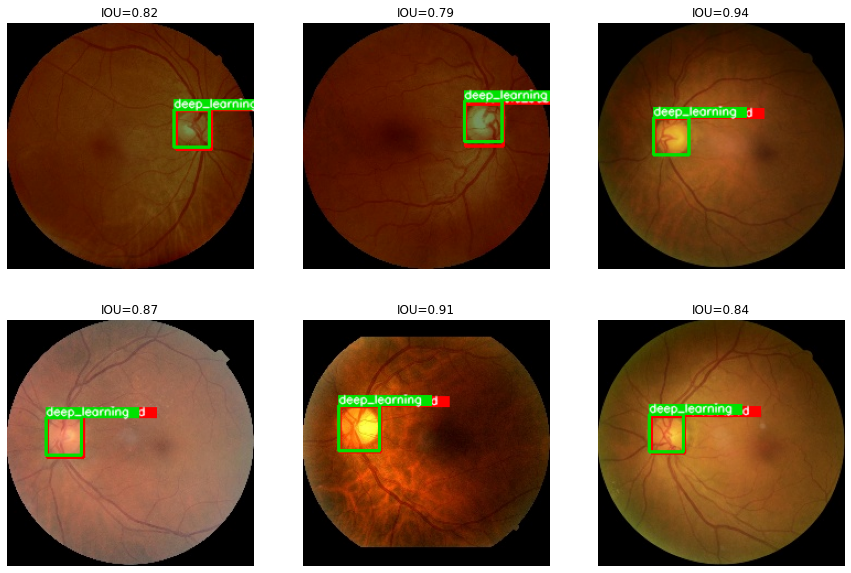

In [18]:
figure = plt.figure(figsize=(15, 10))
cols, rows = 3, 2
for i in range(1, cols * rows + 1):
    sample_idx = samples_idx[6*3:][i-1]
    img, bbox = image_datasets["test"][sample_idx]

    model_ft.eval()
    output = model_ft(img.unsqueeze(0).to(device))    
    output_bbox = output.data.int()[0]
    
    MEAN = torch.tensor([0.485, 0.456, 0.406])
    STD = torch.tensor([0.229, 0.224, 0.225])

    img = img * STD[:, None, None] + MEAN[:, None, None]
    img = (img*255).numpy().astype(np.uint8)
    figure.add_subplot(rows, cols, i)
    plt.title(f"IOU={bbox_iou(bbox, output_bbox):.2f}")
    plt.axis("off")
    bbox_image = image_stuff.draw_bbox(img.transpose(1, 2, 0), bbox, "threshold_based")
    bbox_image = image_stuff.draw_bbox(bbox_image, output_bbox, "deep_learning", box_color=(0, 225, 0))

    
    plt.imshow(bbox_image, cmap="gray")
plt.show()

In [19]:
# torch.save(model_ft.state_dict(), 'model_weights.pth')

In [20]:
# model_ft.load_state_dict(torch.load('model32_weights.pth'))
# model.eval()

In [21]:
torch.save(model_ft, 'model34_2.pth')